In [2]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
# Basics
import tensorflow as tf
import xarray as xr
import random

# Helpful
import tqdm

# Visualization
import matplotlib.pyplot as plt

# My Methods
from src.utils.CRPS import *  # CRPS metrics
from src.utils.data_split import *  # Splitting data into X and y
from src.utils.drn_make_X_array import *  # Import make train array functions (make_X_array)
from src.models.EMOS import *  # EMOS implementation
from src.models.DRN.DRN_model import *  # DRN implementation
from src.models.EMOS_global.EMOS_global_load_score import *  # Load EMOS_global_scores
from src.models.EMOS_global.EMOS_global_load_model import *  # Load EMOS_global_models
from src.models.EMOS_local.EMOS_local_load_score import *  # Load EMOS_local_scores
from src.models.EMOS_local.EMOS_local_load_model import *  # Load EMOS_local_models
import data.raw.load_data_raw as ldr  # Load raw data
import data.processed.load_data_processed as ldp  # Load processed data normed
import data.processed.load_data_processed_denormed as ldpd  # Load processed data denormed
from src.models.CRPS_baseline.CRPS_load import *  # Load CRPS scores

2023-06-08 11:28:59.977470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/opt/anaconda3/lib/
2023-06-08 11:28:59.977499: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<IPython.core.display.Javascript object>

### 0. Setup

In [4]:
var_names = ["u10", "v10", "t2m", "t850", "z500"]
random.seed(7)
# setup:
ran_lat = random.randint(0, 119)
ran_lon = random.randint(0, 129)
ran_forecast_date = random.randint(0, 1428)
ran_lead_time = random.randint(0, 30)
lead_times = [1, 15, 30]  # Lead times to plot boxplot with

<IPython.core.display.Javascript object>

### 1. Load Data

In [5]:
# Raw Data:
dat_raw = ldr.load_data_raw()

# Processese Normed Data
dat_train_norm = ldp.load_data_all_train_proc_norm()
dat_test_norm = ldp.load_data_all_test_proc_norm()

# Processese Denormed Data
dat_train_denorm = ldpd.load_data_all_train_proc_denorm()
dat_test_denorm = ldpd.load_data_all_test_proc_denorm()

<IPython.core.display.Javascript object>

### 2. Lead_time - Ensemble_Values

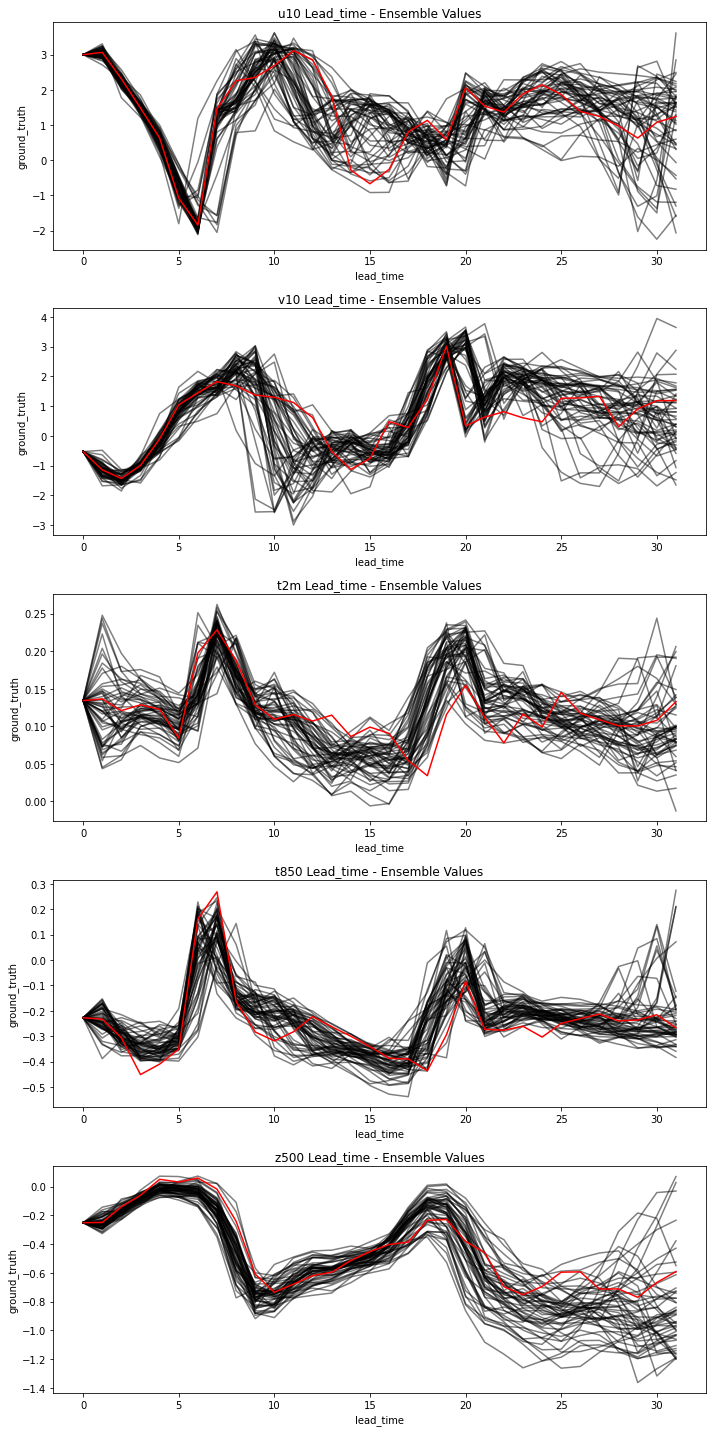

<IPython.core.display.Javascript object>

In [6]:
dat_arr_X = []
dat_arr_y = []
for i in range(5):
    dat_arr_X.append(dat_raw[0].predictions.isel(var=i))
    dat_arr_y.append(dat_raw[0].ground_truth.isel(var=i))

# Generate 3 random variables for lat, lon and forecast_date to visualize for
lat = random.randint(0, 119)  # both border-values included
lon = random.randint(0, 129)
forecast_date = random.randint(0, 356)

fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(10, 20))
for i in range(5):
    dat_arr_X[i].isel(forecast_date=forecast_date, lat=lat, lon=lon).plot(
        x="lead_time", hue="ens", add_legend=False, ax=axs[i], color="black", alpha=0.5
    )
    dat_arr_y[i].isel(forecast_date=forecast_date, lat=lat, lon=lon).plot(
        x="lead_time", ax=axs[i], color="red"
    )
    axs[i].set_title(var_names[i] + " Lead_time - Ensemble Values")
plt.tight_layout()
plt.show()

### 3. Lead_time - Ens_std

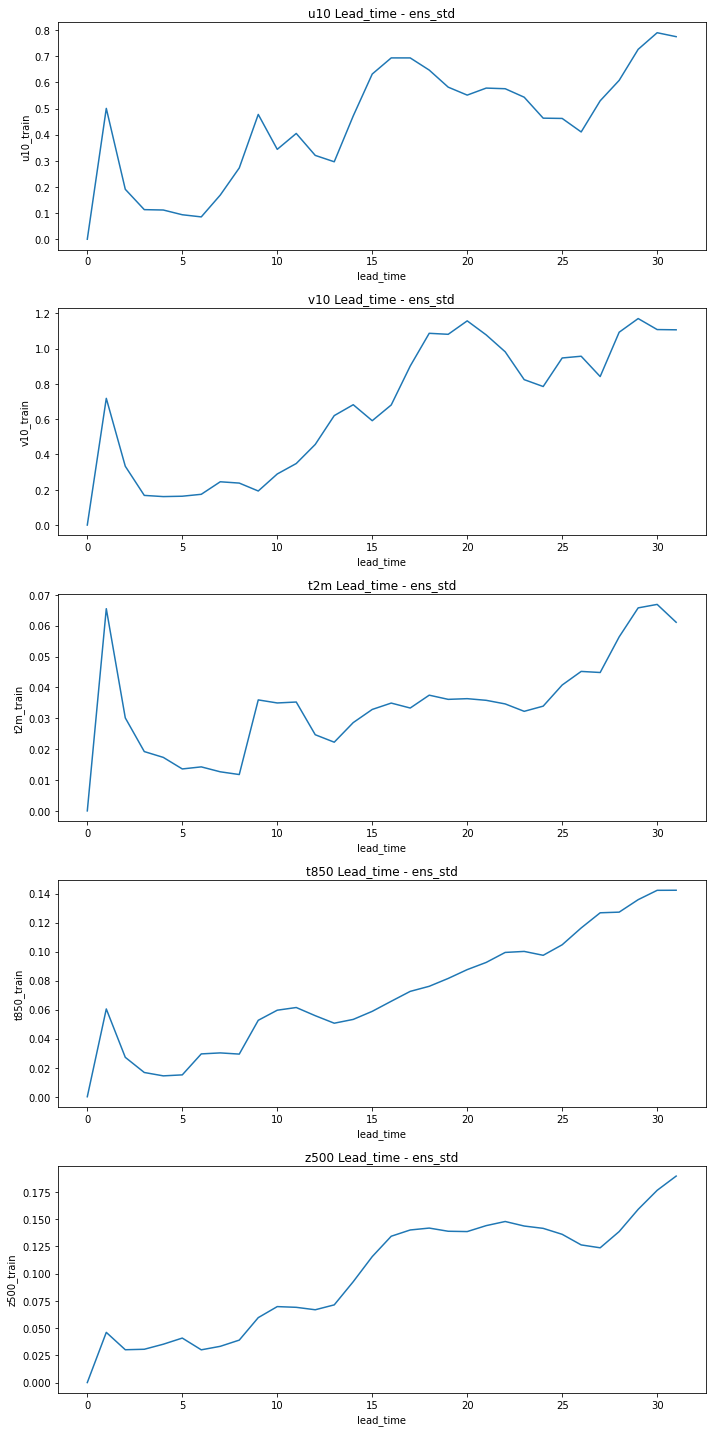

<IPython.core.display.Javascript object>

In [6]:
fig, axs = plt.subplots(ncols=1, nrows=5, figsize=(10, 20))
for i in range(5):
    dat_train_norm[i][var_names[i] + "_train"].isel(
        forecast_date=forecast_date, lat=lat, lon=lon, mean_std=1
    ).plot(x="lead_time", ax=axs[i])
    axs[i].set_title(var_names[i] + " Lead_time - ens_std")
plt.tight_layout()
plt.show()

### 4. Boxplot denormed mean and std

#### 4.1 T2m

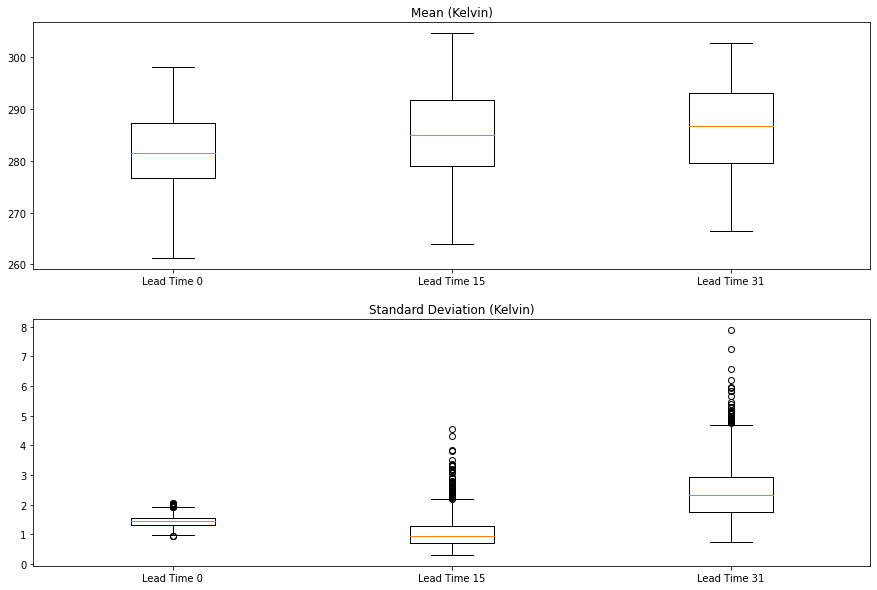

<IPython.core.display.Javascript object>

In [10]:
dat_train_denorm_t2m = dat_train_denorm[2]
# The values of the mean and stds
means_t2m = dat_train_denorm_t2m.t2m_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=0
)
stds_t2m = dat_train_denorm_t2m.t2m_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=1
)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Create an empty lists to store the data for each boxplot
boxplot_means = []
boxplot_stds = []

# Fill the list with data
for i in range(3):
    boxplot_means.append(means_t2m.isel(lead_time=i))
    boxplot_stds.append(stds_t2m.isel(lead_time=i))

# Create boxplots from the data list
axs[0].boxplot(boxplot_means)
axs[1].boxplot(boxplot_stds)

# Add x-axis labels if necessary
axs[0].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[0].set_title("Mean (Kelvin)")

axs[1].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[1].set_title("Standard Deviation (Kelvin)")

plt.show()

#### 4.2 WS10 

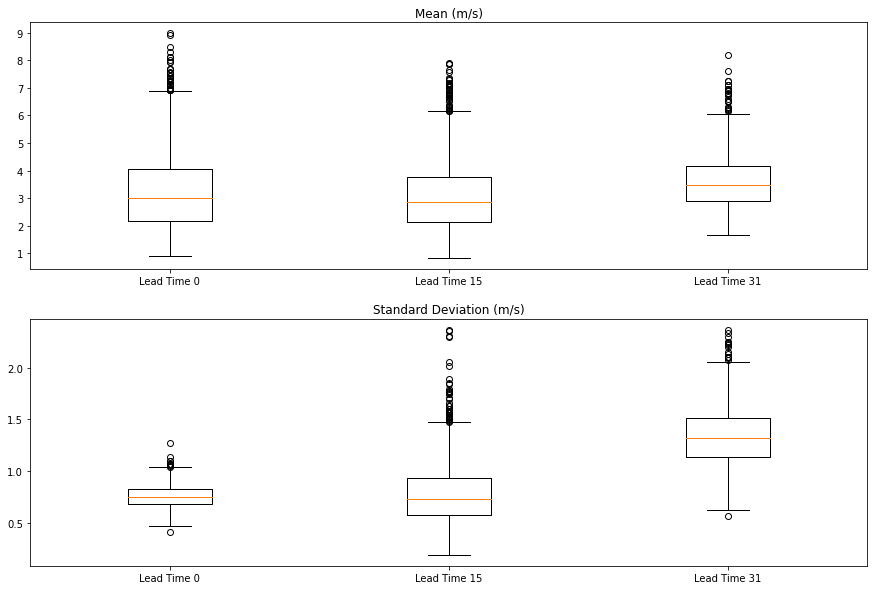

<IPython.core.display.Javascript object>

In [11]:
dat_train_denorm_ws10 = dat_train_denorm[5]
# The values of the mean and stds
means_ws10 = dat_train_denorm_ws10.ws10_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=0
)
stds_ws10 = dat_train_denorm_ws10.ws10_train.isel(
    lat=ran_lat, lon=ran_lon, lead_time=lead_times, mean_std=1
)
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Create an empty lists to store the data for each boxplot
boxplot_means = []
boxplot_stds = []

# Fill the list with data
for i in range(3):
    boxplot_means.append(means_ws10.isel(lead_time=i))
    boxplot_stds.append(stds_ws10.isel(lead_time=i))

# Create boxplots from the data list
axs[0].boxplot(boxplot_means)
axs[1].boxplot(boxplot_stds)

# Add x-axis labels if necessary
axs[0].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[0].set_title("Mean (m/s)")

axs[1].set_xticklabels(["Lead Time 0", "Lead Time 15", "Lead Time 31"])
axs[1].set_title("Standard Deviation (m/s)")

plt.show()

### 5. Heatmaps

#### 5.1 T2m 

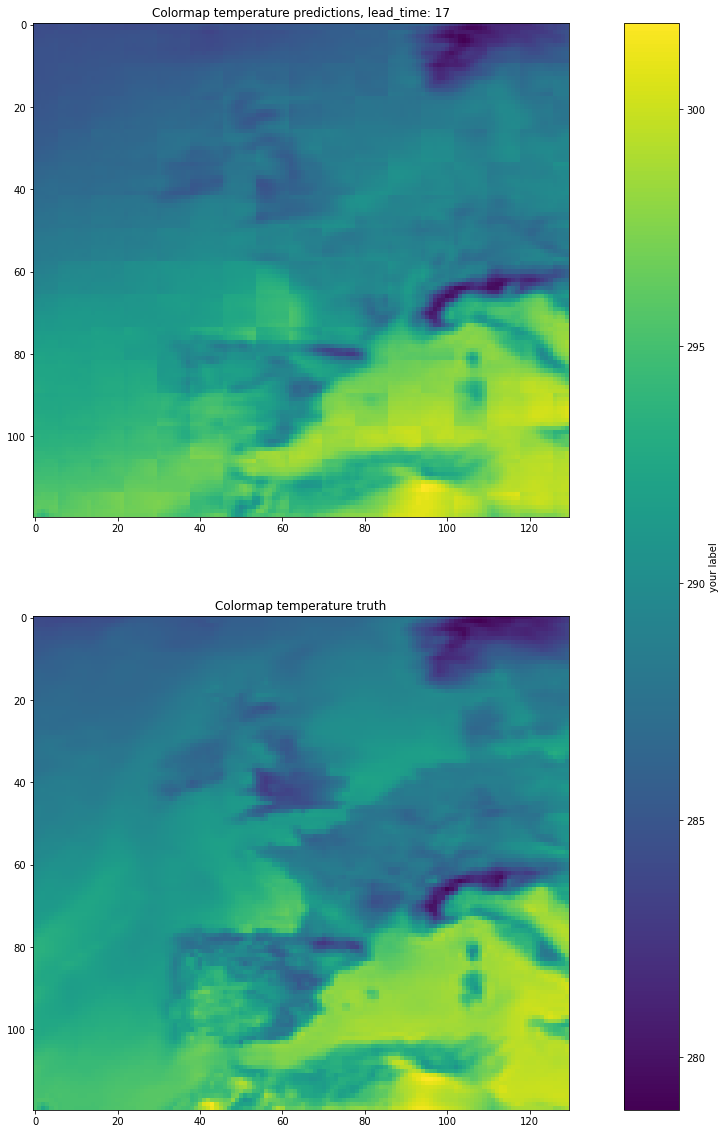

<IPython.core.display.Javascript object>

In [16]:
t2m_preds = dat_train_denorm[2].t2m_train.isel(
    lead_time=ran_lead_time, mean_std=0, forecast_date=ran_forecast_date
)
t2m_truth = dat_train_denorm[2].t2m_truth.isel(
    lead_time=ran_lead_time, forecast_date=ran_forecast_date
)

fig, axs = plt.subplots(2, 1, figsize=(20, 20))

im = axs[0].imshow(t2m_preds.values, cmap="viridis")
im = axs[1].imshow(t2m_truth.values, cmap="viridis")
fig.colorbar(
    im, ax=axs[:], label="your label"
)  # add colorbar to the figure and associate it with the axis
axs[0].set_title(f"Colormap temperature predictions, lead_time: {ran_lead_time}")
axs[1].set_title("Colormap temperature truth")
plt.show()

#### 5.2 WS10

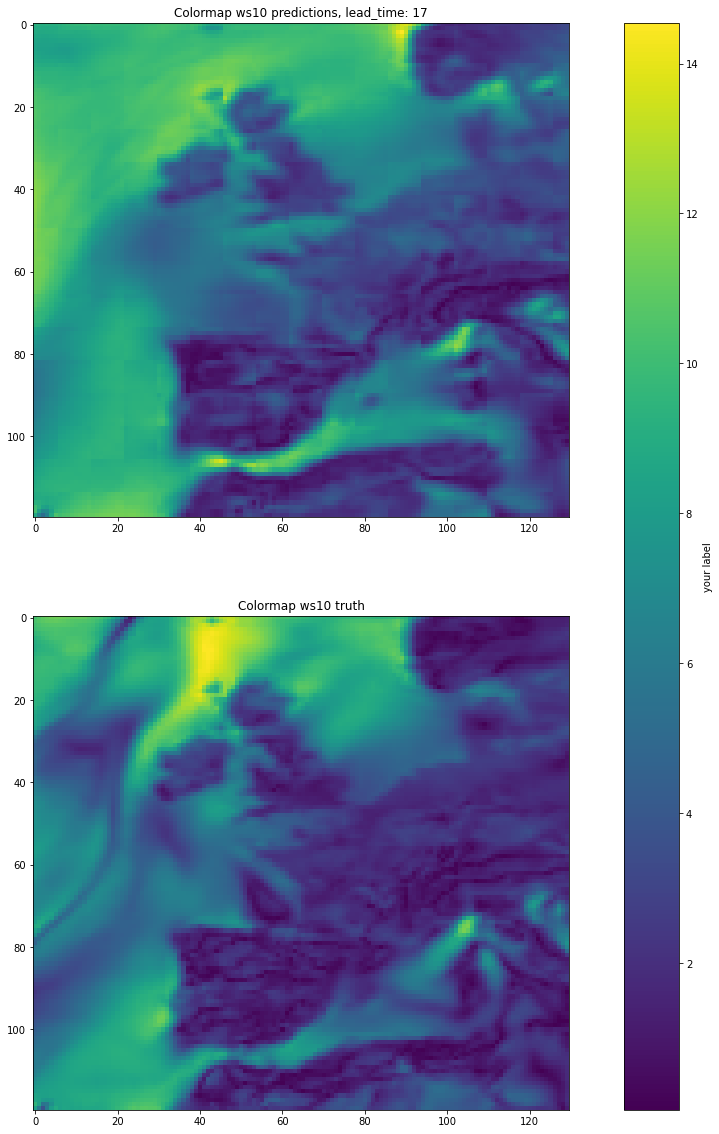

<IPython.core.display.Javascript object>

In [17]:
ws10_preds = dat_train_denorm[5].ws10_train.isel(
    lead_time=ran_lead_time, mean_std=0, forecast_date=ran_forecast_date
)
ws10_truth = dat_train_denorm[5].ws10_truth.isel(
    lead_time=ran_lead_time, forecast_date=ran_forecast_date
)

fig, axs = plt.subplots(2, 1, figsize=(20, 20))

im = axs[0].imshow(ws10_preds.values, cmap="viridis")
im = axs[1].imshow(ws10_truth.values, cmap="viridis")
fig.colorbar(
    im, ax=axs[:], label="your label"
)  # add colorbar to the figure and associate it with the axis
axs[0].set_title(f"Colormap ws10 predictions, lead_time: {ran_lead_time}")
axs[1].set_title("Colormap ws10 truth")
plt.show()